For fine-tuning we have 3 datasets: train, validation and holdout

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn

from scipy import interp
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import os
import time
import h5py

# keras
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence
import keras.backend as K

from config import *
from utils import specificity, sensitivity, balanced_accuracy, IntensityRescale, sagittal_flip, translate, load_nifti

Using TensorFlow backend.


In [2]:
# Start timing
start_time = time.time()

In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "2"
set_session(tf.Session(config=config))

In [4]:
zero_one_normalize = True
dtype = np.float32
z_factor = 0.525
result_dir = "/analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/"

In [5]:
!mkdir -p $result_dir

In [6]:
# load hdf5 files and extract columns
train_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/train_dataset.h5', 'r')
holdout_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/holdout_dataset.h5', 'r')

X_train, y_train = train_h5['X'], train_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [7]:
# convert data to numpy arrays
X_train = np.array(X_train, dtype=dtype)
y_train = np.array(y_train)

X_holdout = np.array(X_holdout, dtype=dtype)
y_holdout = np.array(y_holdout)

In [8]:
print(X_train.shape)

(124, 96, 114, 96)


In [9]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
print("Number of MS patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))

Total datset length: 124
Number of healthy controls: 61
Number of MS patients: 63


In [10]:
class CISDataset(Sequence):
    def __init__(self, X, y, transform=None, batch_size=4, z_factor=None, shuffle=True, mask=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.batch_size = batch_size
        self.z_factor = z_factor
        self.shuffle = shuffle
        self.mask = mask
        
    def __len__(self):
        return int(np.ceil(len(self.y)/self.batch_size))
    
    def __getitem__(self, idx):
        # add BET
        image = np.expand_dims(self.X[idx * self.batch_size:(idx + 1) * self.batch_size],5)
        #label = np.array((batch_idx['label'] == "MS")* 1, dtype=np.int8) 
        label = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype=np.int8)
        
        if self.mask is not None:
            for i in range(image.shape[0]):
                image[i] *= self.mask
        
        for transformation in self.transform:
            image = transformation(image)
        
        return image, label
    
    def on_epoch_end(self):
        if self.shuffle:
            self.X, self.y = shuffle(self.X, self.y)

## Load mask and reformat

In [11]:
mask_path = "/data/Ritter/MS/Test/total_lesion_mask_blurred.nii.gz"

In [12]:
mask = load_nifti(mask_path, z_factor=z_factor)
mask = np.expand_dims(mask, 4)

/home/fabiane/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


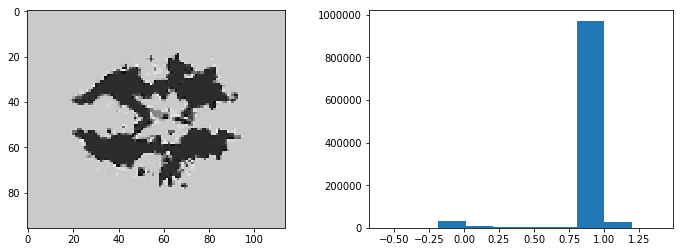

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(mask[:,:,48, 0], cmap='gray')
plt.subplot(1, 2, 2)
plt.hist(mask.flatten())
plt.show()

In [14]:
# after zooming return to binary format
mask[np.where(mask>0.5)] = 1.
mask[np.where(mask<=0.5)] = 0.

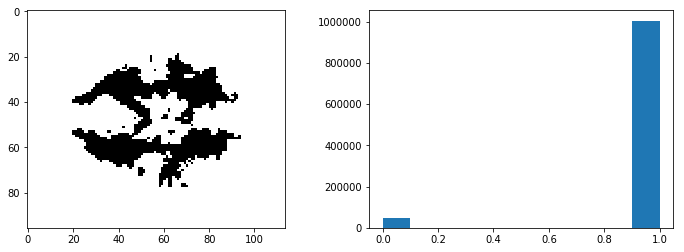

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(mask[:,:,48, 0], cmap='gray')
plt.subplot(1, 2, 2)
plt.hist(mask.flatten())
plt.show()

## Make dataset

In [16]:
intensity = IntensityRescale(masked=False)

In [17]:
if zero_one_normalize:
    cis_data = CISDataset(X_train, y_train, transform=[intensity], batch_size=4, mask=mask)
else:
    cis_data = CISDataset(X_train, y_train, batch_size=4, mask=mask)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


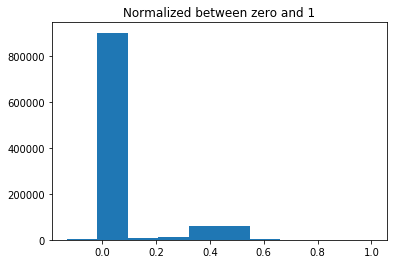

In [18]:
plt.figure()
plt.title("Normalized between zero and 1")
plt.hist(cis_data[4][0][0].flatten())
plt.show()

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


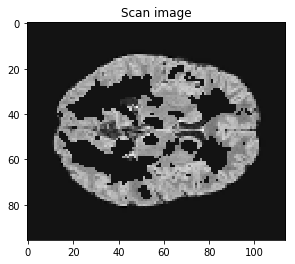

In [19]:
plt.figure()
plt.title("Scan image")
plt.imshow(np.squeeze(cis_data[4][0][0])[:,:,42], cmap='gray')
plt.show()

# Model

In [20]:
def init_model(path, finetune=True, up_to=7):
    model = load_model(path)
    model.load_weights(path)
    if finetune:
        for layer in model.layers[:up_to]:
            layer.trainable = False
    return model

In [21]:
# load model weights
#model_path = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/model.h5"
model_path = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/model_trial_6.h5"
model = init_model(model_path, finetune=False, up_to=None)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv3D)              (None, 94, 112, 94, 64)   1792      
_________________________________________________________________
Pool_1 (MaxPooling3D)        (None, 31, 37, 31, 64)    0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 31, 37, 31, 64)    0         
_________________________________________________________________
Conv_2 (Conv3D)              (None, 29, 35, 29, 64)    110656    
_________________________________________________________________
Pool_2 (MaxPooling3D)        (None, 9, 11, 9, 64)      0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 9, 11, 9, 64)      0         
_________________________________________________________________
Conv_3 (Conv3D)              (None, 7, 9, 7, 64)       110656    
__________

## Visualization

In [22]:
def visualize_weights(model):
    # Visualize weights
    W = model.layers[0].get_weights()[0]
    W = np.squeeze(W)[:,:,2]
    print("W shape : ", W.shape)

    print("Weights mean {}".format(W.mean()))
    plt.figure(figsize=(20, 5))
    plt.title('conv1 weights')
    plt.imshow(make_mosaic(W, 2, 2), cmap="gray")
    plt.show()

In [23]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

In [24]:
def reset_weights(model):
    # Note this only used for visualization below
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)


Pre-trained model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean -0.0010960017098113894


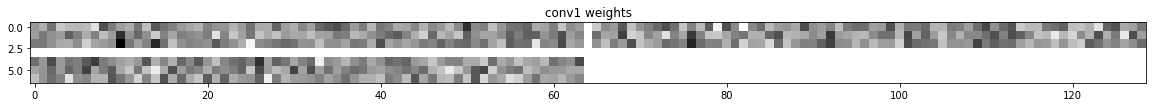

Random model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean -0.000718816474545747


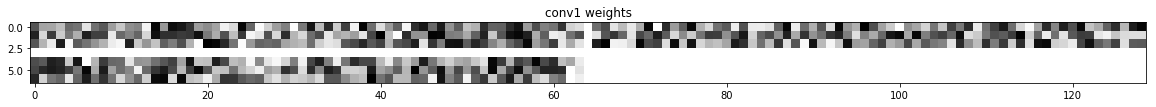

In [25]:
# Visualize weights
print("Pre-trained model layer 1 weights:")
visualize_weights(model)
model_untrained = load_model(model_path)
reset_weights(model_untrained)
print("Random model layer 1 weights:")
visualize_weights(model_untrained)

## Training

In [26]:
X_train.shape

(124, 96, 114, 96)

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
# split training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=77)

Trial 0
Epoch 1/200


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


27/27 [==============================] - 8s 282ms/step - loss: 1.0353 - acc: 0.5376 - val_loss: 0.8653 - val_acc: 0.6842

Epoch 00001: val_acc improved from -inf to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial0-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 152ms/step - loss: 0.9180 - acc: 0.4912 - val_loss: 1.0070 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.68421
Epoch 3/200
27/27 [==============================] - 4s 154ms/step - loss: 0.9161 - acc: 0.5839 - val_loss: 0.9653 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 157ms/step - loss: 0.9274 - acc: 0.4356 - val_loss: 0.9422 - val_acc: 0.3158

Epoch 00004: val_acc did not improve from 0.68421
Epoch 5/200
27/27 [==============================] - 4s 161ms/step - loss: 0.9213 - acc: 0.5005 - val_loss: 0.8755 - val_acc: 0.

27/27 [==============================] - 4s 164ms/step - loss: 0.6230 - acc: 0.7405 - val_loss: 0.8384 - val_acc: 0.3684

Epoch 00043: val_acc did not improve from 0.78947
Epoch 44/200
27/27 [==============================] - 4s 156ms/step - loss: 0.6069 - acc: 0.6952 - val_loss: 0.7012 - val_acc: 0.6842

Epoch 00044: val_acc did not improve from 0.78947
Epoch 45/200
27/27 [==============================] - 4s 163ms/step - loss: 0.6336 - acc: 0.6859 - val_loss: 0.8482 - val_acc: 0.3684

Epoch 00045: val_acc did not improve from 0.78947
Epoch 46/200
27/27 [==============================] - 4s 161ms/step - loss: 0.6073 - acc: 0.7590 - val_loss: 0.7210 - val_acc: 0.6842

Epoch 00046: val_acc did not improve from 0.78947
Epoch 47/200
27/27 [==============================] - 4s 162ms/step - loss: 0.5881 - acc: 0.7497 - val_loss: 0.7570 - val_acc: 0.5789

Epoch 00047: val_acc did not improve from 0.78947
Epoch 48/200
27/27 [==============================] - 4s 153ms/step - loss: 0.5742 - acc

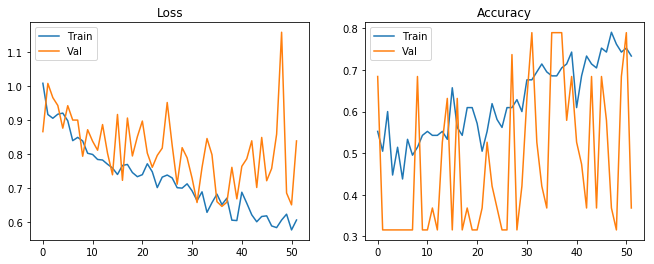

Trial 1
Epoch 1/200
27/27 [==============================] - 5s 204ms/step - loss: 0.9650 - acc: 0.5561 - val_loss: 0.9067 - val_acc: 0.2632

Epoch 00001: val_acc improved from -inf to 0.26316, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial1-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 155ms/step - loss: 0.9604 - acc: 0.4264 - val_loss: 0.8767 - val_acc: 0.5789

Epoch 00002: val_acc improved from 0.26316 to 0.57895, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial1-improvement-BEST.hdf5
Epoch 3/200
27/27 [==============================] - 4s 156ms/step - loss: 0.8966 - acc: 0.5366 - val_loss: 0.8065 - val_acc: 0.7368

Epoch 00003: val_acc improved from 0.57895 to 0.73684, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial1-improvement-

27/27 [==============================] - 4s 162ms/step - loss: 0.6029 - acc: 0.7786 - val_loss: 0.7296 - val_acc: 0.6316

Epoch 00043: val_acc did not improve from 0.73684
Epoch 44/200
27/27 [==============================] - 4s 155ms/step - loss: 0.6196 - acc: 0.7219 - val_loss: 0.7054 - val_acc: 0.6842

Epoch 00044: val_acc did not improve from 0.73684
Epoch 45/200
27/27 [==============================] - 4s 167ms/step - loss: 0.6427 - acc: 0.6859 - val_loss: 0.6550 - val_acc: 0.6842

Epoch 00045: val_acc did not improve from 0.73684
Epoch 46/200
27/27 [==============================] - 4s 160ms/step - loss: 0.6249 - acc: 0.7497 - val_loss: 0.7047 - val_acc: 0.6842

Epoch 00046: val_acc did not improve from 0.73684
Epoch 47/200
27/27 [==============================] - 4s 163ms/step - loss: 0.5722 - acc: 0.7590 - val_loss: 0.6630 - val_acc: 0.7368

Epoch 00047: val_acc did not improve from 0.73684
Epoch 48/200
27/27 [==============================] - 4s 153ms/step - loss: 0.6075 - acc

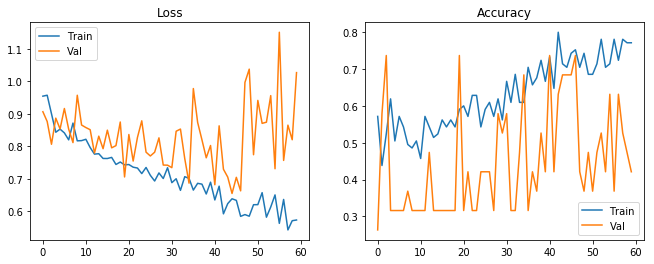

Trial 2
Epoch 1/200
27/27 [==============================] - 5s 198ms/step - loss: 1.0322 - acc: 0.5561 - val_loss: 0.9451 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial2-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 153ms/step - loss: 0.9071 - acc: 0.5551 - val_loss: 0.9384 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.31579
Epoch 3/200
27/27 [==============================] - 5s 170ms/step - loss: 0.8863 - acc: 0.5736 - val_loss: 0.9060 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.31579
Epoch 4/200
27/27 [==============================] - 4s 161ms/step - loss: 0.8889 - acc: 0.5736 - val_loss: 0.8413 - val_acc: 0.6842

Epoch 00004: val_acc improved from 0.31579 to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred

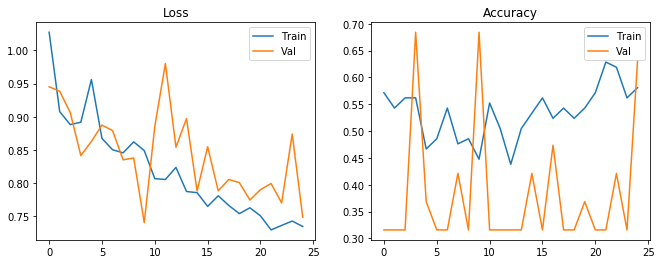

Trial 3
Epoch 1/200
27/27 [==============================] - 6s 212ms/step - loss: 1.1645 - acc: 0.4449 - val_loss: 0.9758 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial3-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 161ms/step - loss: 0.9313 - acc: 0.4634 - val_loss: 1.0184 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.31579
Epoch 3/200
27/27 [==============================] - 4s 163ms/step - loss: 0.9312 - acc: 0.5273 - val_loss: 0.8754 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.31579
Epoch 4/200
27/27 [==============================] - 4s 160ms/step - loss: 0.8896 - acc: 0.5283 - val_loss: 0.8865 - val_acc: 0.3158

Epoch 00004: val_acc did not improve from 0.31579
Epoch 5/200
27/27 [==============================] - 4s 162ms/step - loss: 0.8795 - acc: 0.5088 - val_loss: 

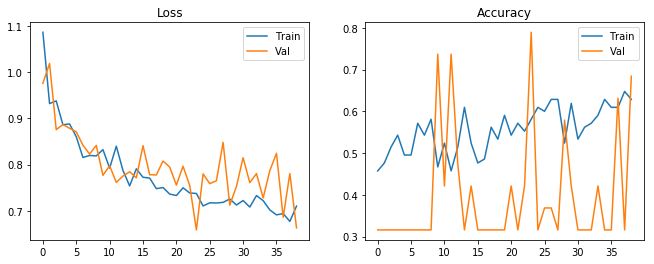

Trial 4
Epoch 1/200
27/27 [==============================] - 6s 219ms/step - loss: 1.0185 - acc: 0.5458 - val_loss: 0.9004 - val_acc: 0.4211

Epoch 00001: val_acc improved from -inf to 0.42105, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial4-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 155ms/step - loss: 0.9496 - acc: 0.4995 - val_loss: 0.8767 - val_acc: 0.6842

Epoch 00002: val_acc improved from 0.42105 to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial4-improvement-BEST.hdf5
Epoch 3/200
27/27 [==============================] - 4s 155ms/step - loss: 0.9196 - acc: 0.5088 - val_loss: 0.9450 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 157ms/step - loss: 0.8930 - acc: 0.4912 - val_loss: 0.8889 - val_acc: 0.3158

Epoch 0

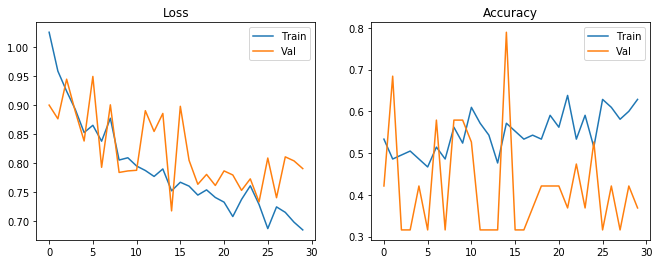

Trial 5
Epoch 1/200
27/27 [==============================] - 6s 218ms/step - loss: 1.0312 - acc: 0.4542 - val_loss: 1.0105 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial5-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 161ms/step - loss: 0.9647 - acc: 0.5088 - val_loss: 0.9230 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.31579
Epoch 3/200
27/27 [==============================] - 4s 164ms/step - loss: 0.9013 - acc: 0.5283 - val_loss: 0.9282 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.31579
Epoch 4/200
27/27 [==============================] - 4s 165ms/step - loss: 0.9324 - acc: 0.5366 - val_loss: 0.9128 - val_acc: 0.3158

Epoch 00004: val_acc did not improve from 0.31579
Epoch 5/200
27/27 [==============================] - 4s 165ms/step - loss: 0.8655 - acc: 0.5366 - val_loss: 

27/27 [==============================] - 4s 156ms/step - loss: 0.6890 - acc: 0.6663 - val_loss: 0.7678 - val_acc: 0.4737

Epoch 00041: val_acc did not improve from 0.73684
Epoch 42/200
27/27 [==============================] - 5s 168ms/step - loss: 0.6842 - acc: 0.5839 - val_loss: 0.6847 - val_acc: 0.6316

Epoch 00042: val_acc did not improve from 0.73684
Epoch 43/200
27/27 [==============================] - 4s 154ms/step - loss: 0.7029 - acc: 0.6293 - val_loss: 0.6854 - val_acc: 0.7368

Epoch 00043: val_acc did not improve from 0.73684
Epoch 44/200
27/27 [==============================] - 4s 161ms/step - loss: 0.7120 - acc: 0.6293 - val_loss: 0.8078 - val_acc: 0.2632

Epoch 00044: val_acc did not improve from 0.73684
Epoch 45/200
27/27 [==============================] - 4s 159ms/step - loss: 0.6726 - acc: 0.7497 - val_loss: 0.7228 - val_acc: 0.6842

Epoch 00045: val_acc did not improve from 0.73684
Epoch 46/200
27/27 [==============================] - 4s 163ms/step - loss: 0.6586 - acc

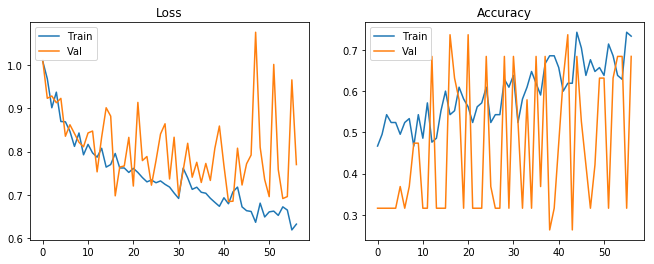

Trial 6
Epoch 1/200
27/27 [==============================] - 7s 249ms/step - loss: 1.0773 - acc: 0.3893 - val_loss: 0.9238 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial6-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 158ms/step - loss: 0.9561 - acc: 0.4439 - val_loss: 0.9318 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.31579
Epoch 3/200
27/27 [==============================] - 4s 163ms/step - loss: 0.9299 - acc: 0.4810 - val_loss: 0.8811 - val_acc: 0.3684

Epoch 00003: val_acc improved from 0.31579 to 0.36842, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial6-improvement-BEST.hdf5
Epoch 4/200
27/27 [==============================] - 4s 159ms/step - loss: 0.8596 - acc: 0.5736 - val_loss: 0.8883 - val_acc: 0.3158

Epoch 0

27/27 [==============================] - 4s 161ms/step - loss: 0.6463 - acc: 0.7137 - val_loss: 0.7411 - val_acc: 0.4737

Epoch 00043: val_acc did not improve from 0.63158
Epoch 44/200
27/27 [==============================] - 4s 162ms/step - loss: 0.6601 - acc: 0.6663 - val_loss: 0.7073 - val_acc: 0.5789

Epoch 00044: val_acc did not improve from 0.63158
Epoch 45/200
27/27 [==============================] - 4s 155ms/step - loss: 0.6270 - acc: 0.7219 - val_loss: 0.6531 - val_acc: 0.7368

Epoch 00045: val_acc improved from 0.63158 to 0.73684, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial6-improvement-BEST.hdf5
Epoch 46/200
27/27 [==============================] - 4s 164ms/step - loss: 0.6359 - acc: 0.6941 - val_loss: 0.7074 - val_acc: 0.5263

Epoch 00046: val_acc did not improve from 0.73684
Epoch 47/200
27/27 [==============================] - 4s 164ms/step - loss: 0.6531 - acc: 0.7034 - val_loss: 0.7093 - val_

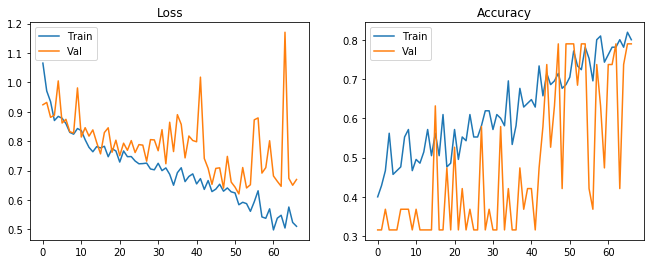

Trial 7
Epoch 1/200
27/27 [==============================] - 7s 243ms/step - loss: 1.0050 - acc: 0.5005 - val_loss: 0.9484 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial7-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 160ms/step - loss: 0.9766 - acc: 0.5088 - val_loss: 0.8770 - val_acc: 0.6316

Epoch 00002: val_acc improved from 0.31579 to 0.63158, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial7-improvement-BEST.hdf5
Epoch 3/200
27/27 [==============================] - 4s 163ms/step - loss: 0.9142 - acc: 0.5273 - val_loss: 0.9012 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.63158
Epoch 4/200
27/27 [==============================] - 4s 163ms/step - loss: 0.8593 - acc: 0.5736 - val_loss: 0.8630 - val_acc: 0.3158

Epoch 0

27/27 [==============================] - 4s 159ms/step - loss: 0.6575 - acc: 0.7034 - val_loss: 0.9767 - val_acc: 0.3158

Epoch 00043: val_acc did not improve from 0.78947
Epoch 44/200
27/27 [==============================] - 4s 163ms/step - loss: 0.6579 - acc: 0.7127 - val_loss: 0.7942 - val_acc: 0.4737

Epoch 00044: val_acc did not improve from 0.78947
Epoch 45/200
27/27 [==============================] - 4s 163ms/step - loss: 0.6018 - acc: 0.7590 - val_loss: 0.7008 - val_acc: 0.6316

Epoch 00045: val_acc did not improve from 0.78947
Epoch 46/200
27/27 [==============================] - 5s 168ms/step - loss: 0.5824 - acc: 0.7590 - val_loss: 0.7096 - val_acc: 0.6316

Epoch 00046: val_acc did not improve from 0.78947
Epoch 47/200
27/27 [==============================] - 5s 177ms/step - loss: 0.6277 - acc: 0.6581 - val_loss: 0.7173 - val_acc: 0.6316

Epoch 00047: val_acc did not improve from 0.78947
Epoch 48/200
27/27 [==============================] - 4s 156ms/step - loss: 0.6154 - acc

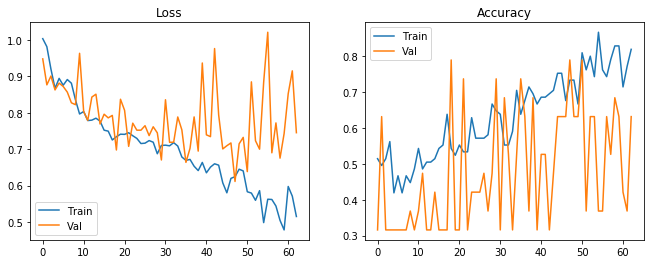

Trial 8
Epoch 1/200
27/27 [==============================] - 7s 243ms/step - loss: 1.0980 - acc: 0.4995 - val_loss: 0.9995 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial8-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 158ms/step - loss: 0.9134 - acc: 0.5283 - val_loss: 0.8689 - val_acc: 0.6842

Epoch 00002: val_acc improved from 0.31579 to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial8-improvement-BEST.hdf5
Epoch 3/200
27/27 [==============================] - 4s 167ms/step - loss: 0.9516 - acc: 0.5469 - val_loss: 0.9207 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 158ms/step - loss: 0.9370 - acc: 0.4810 - val_loss: 1.0477 - val_acc: 0.3158

Epoch 0

Epoch 00042: early stopping


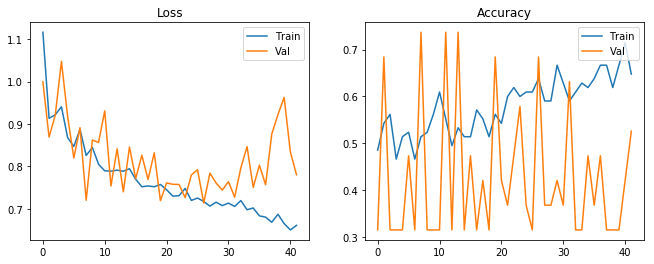

Trial 9
Epoch 1/200
27/27 [==============================] - 7s 270ms/step - loss: 0.9904 - acc: 0.5366 - val_loss: 0.9398 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial9-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 159ms/step - loss: 0.9556 - acc: 0.5458 - val_loss: 0.8638 - val_acc: 0.6842

Epoch 00002: val_acc improved from 0.31579 to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial9-improvement-BEST.hdf5
Epoch 3/200
27/27 [==============================] - 4s 164ms/step - loss: 0.9112 - acc: 0.5644 - val_loss: 0.9030 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 163ms/step - loss: 0.8997 - acc: 0.5273 - val_loss: 0.9276 - val_acc: 0.3158

Epoch 0

27/27 [==============================] - 5s 170ms/step - loss: 0.6749 - acc: 0.6663 - val_loss: 0.6840 - val_acc: 0.6842

Epoch 00043: val_acc did not improve from 0.73684
Epoch 44/200
27/27 [==============================] - 4s 162ms/step - loss: 0.6751 - acc: 0.6210 - val_loss: 0.8130 - val_acc: 0.4211

Epoch 00044: val_acc did not improve from 0.73684
Epoch 45/200
27/27 [==============================] - 5s 169ms/step - loss: 0.6206 - acc: 0.7219 - val_loss: 0.7195 - val_acc: 0.6316

Epoch 00045: val_acc did not improve from 0.73684
Epoch 46/200
27/27 [==============================] - 4s 165ms/step - loss: 0.6197 - acc: 0.7497 - val_loss: 1.2294 - val_acc: 0.3158

Epoch 00046: val_acc did not improve from 0.73684
Epoch 47/200
27/27 [==============================] - 4s 165ms/step - loss: 0.6620 - acc: 0.6385 - val_loss: 0.8386 - val_acc: 0.3684

Epoch 00047: val_acc did not improve from 0.73684
Epoch 48/200
27/27 [==============================] - 4s 164ms/step - loss: 0.6240 - acc

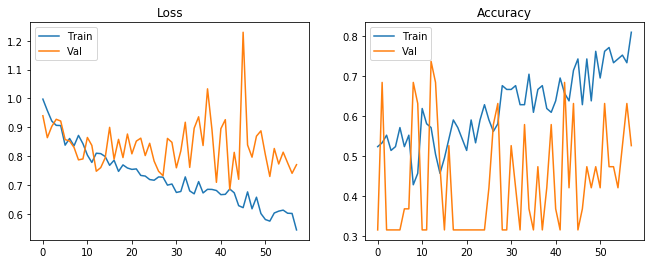

Training Time: 0.0h:37.0m:53.98998165130615s
Validation final accuracies: 
 [0.3684210526315789, 0.42105263157894735, 0.631578947368421, 0.6842105263157895, 0.3684210526315789, 0.6842105263157895, 0.7894736842105263, 0.631578947368421, 0.5263157894736842, 0.5263157894736842]
Validation final accuracies mean: 0.5631578947368421
Validation best accuracies: 
 [0.7894736842105263, 0.7368421052631579, 0.6842105263157895, 0.7894736842105263, 0.7894736842105263, 0.7368421052631579, 0.7894736842105263, 0.7894736842105263, 0.7368421052631579, 0.7368421052631579]
Validation best accuracies mean: 0.7578947368421052
Validation balanced accuracies: 
 [0.4487179487179487, 0.5769230769230769, 0.6858974358974359, 0.6346153846153846, 0.4935897435897436, 0.7243589743589745, 0.7115384615384616, 0.5961538461538461, 0.5641025641025641, 0.5192307692307692]
Validation balanced accuracies mean: 0.5955128205128204
Validation final sensitivities: 
 [0.6666666666666666, 1.0, 0.8333333333333334, 0.5, 0.8333333333

In [29]:
# training args
lr = 0.0005
lr_decay = 0.001
transforms = [intensity, sagittal_flip, translate]

num_trials = 10
store_models = True

# callbacks
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

accuracies = []
balanced_accuracies = []
sensitivities = []
specificities = []
max_acc = []

for i in range(num_trials):
    print("Trial %i" %i)
    
    # init model
    model = init_model(model_path, finetune=False, up_to=None)    
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(optimizer=opti, loss='binary_crossentropy', metrics=['accuracy'])
    
    # callbacks
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')
    if store_models:
        result_path = os.path.join(result_dir, "weights-augm-trial%i-improvement-BEST.hdf5" %i)
        model_checkpoint = ModelCheckpoint(result_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
        callbacks = [earlystop, model_checkpoint]
    else:
        callbacks = [earlystop]
        
    train_loader = CISDataset(X_train, y_train, transform=transforms, batch_size=b, shuffle=True, mask=mask)
    val_loader = CISDataset(X_val, y_val, transform=[intensity], batch_size=1, shuffle=False, mask=mask)
    
    # Start training
    history = model.fit_generator(train_loader,
                        epochs=num_epochs,
                        verbose=1,
                        validation_data=val_loader,
                        callbacks=callbacks)
    # Plot training curves
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Val"])
    plt.title("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.legend(["Train", "Val"])
    plt.title("Accuracy")
    plt.show()
    # Evaluation
    y_pred = model.predict_generator(val_loader)
    #y_true = [item for sublist in [val_loader[batch_idx][1] for batch_idx in range(len(val_loader))] for item in sublist]
    bal_acc = balanced_accuracy(y_val, y_pred>0.5)
    sens = sensitivity(y_val, y_pred>0.5)
    spec = specificity(y_val, y_pred>0.5)
    # Store results
    accuracies.append(history.history["val_acc"][-1])
    balanced_accuracies.append(bal_acc)
    max_acc.append(np.max(history.history["val_acc"]))
    sensitivities.append(sens)
    specificities.append(spec)

training_time = time.time() - start_time
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))

print("Validation final accuracies: \n {}".format(accuracies))
print("Validation final accuracies mean: {}".format(np.mean(accuracies)))
print("Validation best accuracies: \n {}".format(max_acc))
print("Validation best accuracies mean: {}".format(np.mean(max_acc)))
print("Validation balanced accuracies: \n {}".format(balanced_accuracies))
print("Validation balanced accuracies mean: {}".format(np.mean(balanced_accuracies)))
print("Validation final sensitivities: \n {}".format(sensitivities))
print("Validation final sensitivities' mean: {}".format(np.mean(sensitivities)))
print("Validation final specificities: \n {}".format(specificities))
print("Validation final specificities' mean: {}".format(np.mean(specificities)))

In [30]:
training_time = time.time() - start_time

# Evaluation

In [31]:
weights = ["weights-augm-trial%i-improvement-BEST.hdf5"%i for i in range(num_trials)]

In [32]:
result_dir + weights[0]

'/analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial0-improvement-BEST.hdf5'

In [33]:
# load holdout set
test_loader = CISDataset(X_holdout, y_holdout, transform=[intensity], batch_size=1, shuffle=False, mask=mask)

Fold 0


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 56.52 %
Balanced accuracy 59.23 %
Sensitivity 38.46 %
Specificity 80.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 60.00
Fold 1


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 43.48 %
Balanced accuracy 48.85 %
Sensitivity 7.69 %
Specificity 90.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 50.00
Fold 2


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 43.48 %
Balanced accuracy 50.00 %
Sensitivity 0.00 %
Specificity 100.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 29.23
Fold 3


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 43.48 %
Balanced accuracy 48.85 %
Sensitivity 7.69 %
Specificity 90.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 56.92
Fold 4


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 34.78 %
Balanced accuracy 40.00 %
Sensitivity 0.00 %
Specificity 80.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 50.00
Fold 5


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 43.48 %
Balanced accuracy 48.85 %
Sensitivity 7.69 %
Specificity 90.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 63.08
Fold 6


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 65.22 %
Balanced accuracy 65.77 %
Sensitivity 61.54 %
Specificity 70.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 62.31
Fold 7


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 39.13 %
Balanced accuracy 42.69 %
Sensitivity 15.38 %
Specificity 70.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 45.38
Fold 8


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 47.83 %
Balanced accuracy 53.85 %
Sensitivity 7.69 %
Specificity 100.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 61.54
Fold 9


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 43.48 %
Balanced accuracy 45.38 %
Sensitivity 30.77 %
Specificity 60.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 49.23
######## Final results ########
Accuracy mean 46.09 %
Balanced accuracy mean 50.35 %
Sensitivity mean 17.69 %
Specificity mean 83.00 %
Mean ROC AUC score 52.77


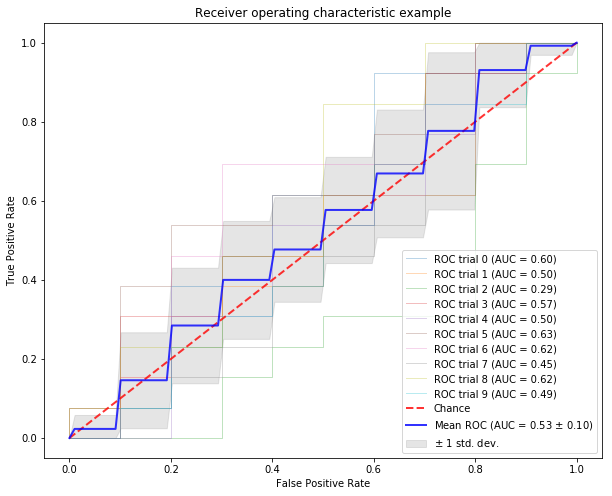

In [34]:
accuracies = []
balanced_accuracies = []
sensitivities = []
specificities = []
auc_scores = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))

for fold, weight in enumerate(weights):
    print("Fold {}".format(fold))
    model = load_model(model_path)
    model_dir = os.path.join(result_dir, weight)
    model.load_weights(model_dir)
    
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(optimizer=opti,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    # Evaluate
    res = model.evaluate_generator(test_loader)
    y_pred = model.predict_generator(test_loader)
    #for pred, true in zip(y_pred, y_holdout):
    #    print(pred)
    #    print(true)
    bal_acc = balanced_accuracy(y_holdout, y_pred>0.5)
    sens = sensitivity(y_holdout, y_pred>0.5)
    spec = specificity(y_holdout, y_pred>0.5)
    roc_auc = roc_auc_score(y_holdout, y_pred)
    fpr, tpr, thresholds = roc_curve(y_holdout, y_pred)   
    # Store results
    accuracies.append(res[1])
    balanced_accuracies.append(bal_acc)
    sensitivities.append(sens)
    specificities.append(spec)
    auc_scores.append(roc_auc)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    # Print results
    print("Model accuracy {:.2f} %".format(res[1]*100))
    print("Balanced accuracy {:.2f} %".format(bal_acc*100))
    print("Sensitivity {:.2f} %".format(sens*100))
    print("Specificity {:.2f} %".format(spec*100))
    print("Area Under the Receiver Operating Curve (ROC AUC score) {:.2f}".format(roc_auc*100))
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC trial %d (AUC = %0.2f)' % (fold, roc_auc))
    
print("######## Final results ########")
print("Accuracy mean {:.2f} %".format(np.mean(accuracies)*100))
print("Balanced accuracy mean {:.2f} %".format(np.mean(balanced_accuracies)*100))
print("Sensitivity mean {:.2f} %".format(np.mean(sensitivities)*100))
print("Specificity mean {:.2f} %".format(np.mean(specificities)*100))
print("Mean ROC AUC score {:.2f}".format(np.mean(auc_scores)*100))

# Plot ROC Curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
#assert(mean_auc == np.mean(auc_scores))
std_auc = np.std(auc_scores)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (np.mean(auc_scores), std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [35]:
total_time = time.time() - start_time

In [36]:
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))
print("Total time elapsed: {}h:{}m:{}s".format(
            total_time//3600, (total_time//60)%60, total_time%60))

Training Time: 0.0h:37.0m:54.00249147415161s
Total time elapsed: 0.0h:39.0m:33.28968143463135s


In [37]:
quit()